In [1]:
from glob import glob
import os
import shutil

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

make path for image classification

In [2]:
os.makedirs('../working/idc2/idc-minus/')     
os.makedirs('../working/idc2/idc-plus/')  

# **Image Import**
for first time run uncomment this cell
this will catagorise files into different directory
for second time run please comment this cell

In [3]:

from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays
# Two arrays holding images by class type

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model
sampling_seed=0
size_4_training=5000
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class1sample=random.sample(class1,size_4_training)


../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_cla

Image classification

In [4]:

def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
            '''
            # first co
            status1=img = cv2.imread(i ,cv2.IMREAD_COLOR)
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            status2=cv2.imwrite(outputname,img)
            
            '''
            
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0path='../working/idc2/idc-minus/'
class1path='../working/idc2/idc-plus/'




read_and_save_data(class0path,class0sample)
read_and_save_data(class1path,class1sample)

In [5]:
data_dir = "../working/idc2"
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 120, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 120, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 7000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [6]:
def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [7]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
def get_models():
    ANN = Sequential()
    ANN.add(Dense(4096, input_dim = X_train.shape[1], activation = 'relu'))
    ANN.add(BatchNormalization())
    ANN.add(Dense(4096, activation='relu'))
    ANN.add(Dropout(0.2))
    ANN.add(Dense(2096, activation='relu'))
    #ANN.add(Dense(16, activation='relu'))
    #ANN.add(Dense(8, activation='relu'))
    ANN.add(Dense(len(train_it.class_indices), activation='sigmoid'))
    

    opt = Adam(learning_rate=0.001)
    ANN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
 
    KNN = KNeighborsClassifier()
    
    SVM = SVC(kernel = 'linear')
    
    RF = RandomForestClassifier(n_estimators = 50)
    
    ADB = AdaBoostClassifier()
    
    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)
    
    print("Defined------->")
    print("ANN -------->", "(128x64x32x16x8)")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    
    return (ANN, KNN, SVM, RF, ADB, XGB)

In [8]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))
    
    return (X_train, X_val, X_test)

In [9]:
from tensorflow.keras.utils import to_categorical
def fit_ANN(model, X_train, y_train, X_val, y_test):
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint('ANN.hdf5', save_best_only=True)]
    y_train=to_categorical(y_train)
    y_test=to_categorical(y_test)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_test), epochs=10, verbose=1, callbacks=callbacks)
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
def get_accuracy_metrics_for_ANN(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.summary()
    plot_model(model, to_file='ANN.png', show_shapes=True,show_layer_names=True)
    Image(filename='ANN.png') 
    #y_train=np.argmax(y_train, axis=1)
    #y_test=np.argmax(y_test, axis=1)
    #y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, np.argmax(model.predict(X_train), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    #val_pred = np.argmax(model.predict(X_val), axis = 1)
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
    #predicted =  np.argmax(model.predict(X_test), axis = 1)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [10]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    pca = PCA(n_components=1000)
    randlist = random.sample(range(0, X_train.shape[0]), 1000)
    if(X_train.shape[1] > 10000):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)
    
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

# VGG 16

In [11]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')
#base_model = VGG16(include_top=False, input_shape=(SIZE_X, SIZE_Y, 2), weights='imagenet')


for layer in base_model.layers:
    layer.trainable = False
                   
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary()

2022-05-09 02:45:50.109727: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58900480/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

# here is the input place of data

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

2022-05-09 02:45:55.990123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Shape of X_train-----> (7000, 7, 7, 512)
Shape of X_val-----> (1500, 7, 7, 512)
Shape of X_test-----> (1500, 7, 7, 512)


In [13]:
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
ANN, KNN, SVM, RF, ADB, XGB = get_models()

ANN = fit_ANN(ANN, X_train, y_train, X_val, y_val)

Shape after reshaping------->
X train-------> (7000, 25088)
X val--------> (1500, 25088)
X test--------> (1500, 25088)
Defined------->
ANN --------> (128x64x32x16x8)
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
Epoch 1/10
219/219 [==============================] - 86s 389ms/step - loss: 0.6341 - accuracy: 0.7769 - val_loss: 0.5141 - val_accuracy: 0.7753
Epoch 2/10
219/219 [==============================] - 85s 384ms/step - loss: 0.3469 - accuracy: 0.8577 - val_loss: 0.6020 - val_accuracy: 0.7527
Epoch 3/10
219/219 [==============================] - 84s 383ms/step - loss: 0.2252 - accuracy: 0.9131 - val_loss: 0.6727 - val_accuracy: 0.7680
Epoch 4/10
219/219 [==============================] - 83s 381ms/step - loss: 0.1635 - accuracy: 0.9341 - val_loss: 0.9550 - val_accuracy: 0.7360
Epoch 5/10
219/219 [==============================] - 84s 385ms/step - loss: 0.1263 - accuracy: 0.9523 - val_los

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2096)              8587312   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4194      
Total params: 128,153,746
Trainable params: 128,145,554
Non-trainable params: 8,192
______________________________________

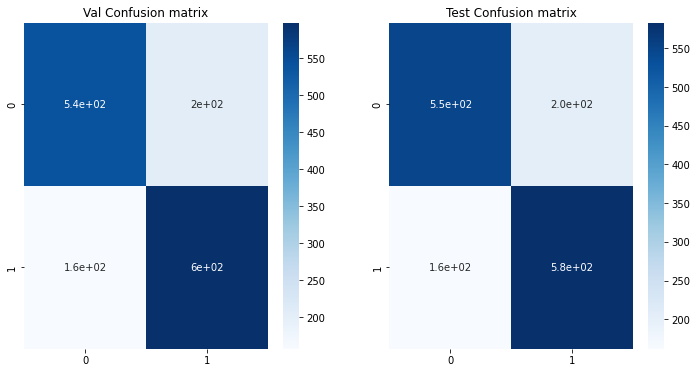

In [14]:
get_accuracy_metrics_for_ANN(ANN, X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
83.900 %
Val accuracy Score--------->
73.867 %
Test accuracy Score--------->
74.267 %
F1 Score--------------->
74.199 %
Cohen Kappa Score------------->
48.569 %
Recall-------------->
74.267 %
Precision-------------->
74.579 %


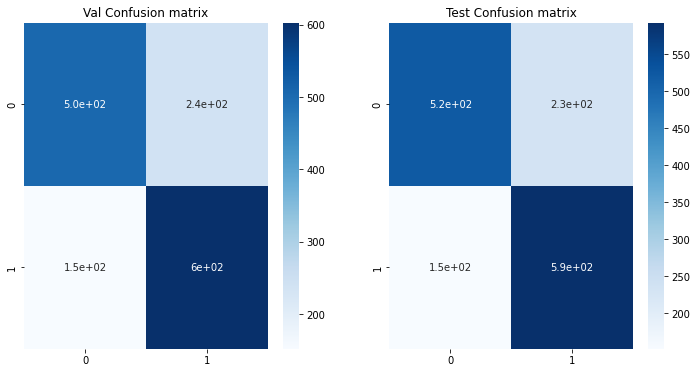

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
72.133 %
Test accuracy Score--------->
70.533 %
F1 Score--------------->
70.497 %
Cohen Kappa Score------------->
41.094 %
Recall-------------->
70.533 %
Precision-------------->
70.672 %


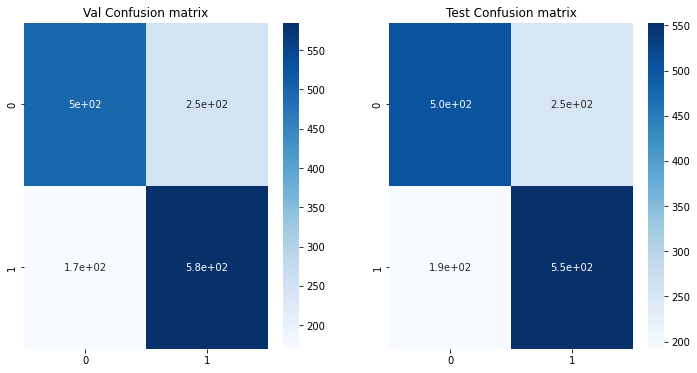

In [16]:
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
75.200 %
Test accuracy Score--------->
76.133 %
F1 Score--------------->
76.134 %
Cohen Kappa Score------------->
52.266 %
Recall-------------->
76.133 %
Precision-------------->
76.135 %


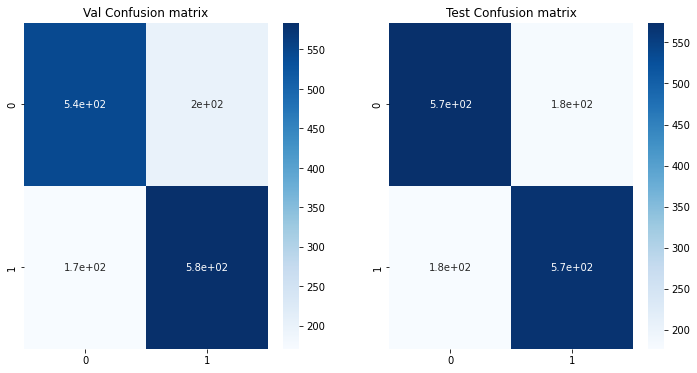

In [17]:
RF = fit_model(RF, X_train, y_train)
get_accuracy_metrics(RF,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
81.000 %
Val accuracy Score--------->
74.467 %
Test accuracy Score--------->
74.667 %
F1 Score--------------->
74.622 %
Cohen Kappa Score------------->
49.362 %
Recall-------------->
74.667 %
Precision-------------->
74.886 %


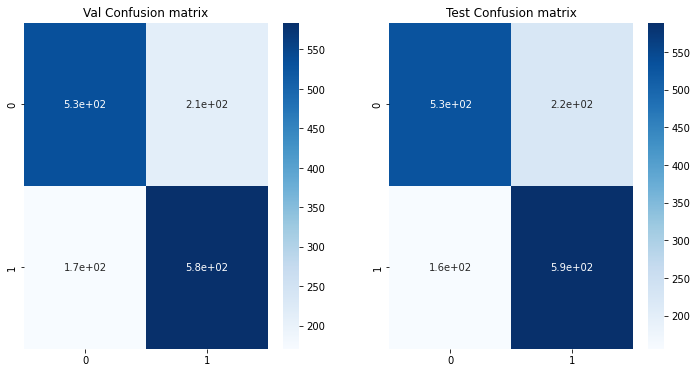

In [18]:
ADB = fit_model(ADB, X_train, y_train)
get_accuracy_metrics(ADB,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
99.843 %
Val accuracy Score--------->
76.800 %
Test accuracy Score--------->
75.733 %
F1 Score--------------->
75.715 %
Cohen Kappa Score------------->
51.484 %
Recall-------------->
75.733 %
Precision-------------->
75.840 %


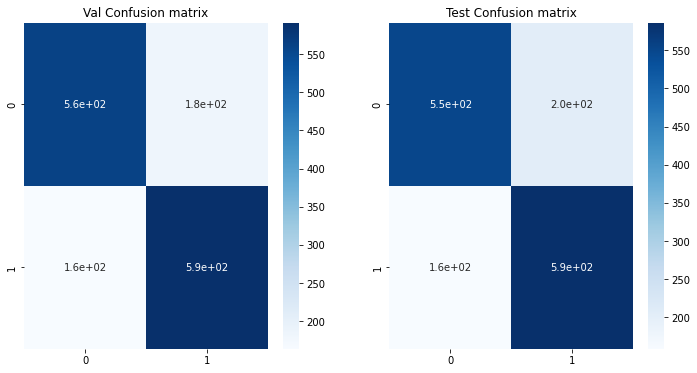

In [19]:
XGB = fit_model(XGB, X_train, y_train)
get_accuracy_metrics(XGB,  X_train, y_train, X_val, y_val, X_test, y_test)